In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import requests
import nltk
import string
import re
import os

In [5]:
from os import path
from PIL import Image
from bs4 import BeautifulSoup
from time import sleep
from collections import Counter
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import confusion_matrix

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'wordcloud'

In [4]:
raw_data = pd.read_csv('Sentiment.csv', encoding='utf-8')

In [5]:
raw_data.tail()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
13866,13867,No candidate mentioned,1.0000,yes,1.0000,Negative,0.7991,Abortion,0.6014,No candidate mentioned,...,yes,7,Negative,Abortion\nWomen's Issues (not abortion though),RT @cappy_yarbrough: Love to see men who will ...,NaN,2015-08-07 09:29:43 -0700,629690895479250944,Como,NaN
13867,13868,Mike Huckabee,0.9611,yes,1.0000,Positive,0.7302,None of the above,0.9229,Mike Huckabee,...,yes,1,NaN,NaN,RT @georgehenryw: Who thought Huckabee exceede...,NaN,2015-08-07 09:25:02 -0700,629689719056568320,USA,NaN
13868,13869,Ted Cruz,1.0000,yes,1.0000,Positive,0.8051,None of the above,0.9647,Ted Cruz,...,yes,67,Positive\nNeutral,NaN,"RT @Lrihendry: #TedCruz As President, I will a...",NaN,2015-08-07 07:19:18 -0700,629658075784282112,NaN,NaN
13869,13870,Donald Trump,1.0000,yes,1.0000,Negative,1.0000,Women's Issues (not abortion though),0.9202,Donald Trump,...,yes,149,NaN,Women's Issues (not abortion though),RT @JRehling: #GOPDebate Donald Trump says tha...,NaN,2015-08-07 09:54:04 -0700,629697023663546368,NaN,NaN
13870,13871,Ted Cruz,0.9242,yes,0.9614,Positive,0.9614,None of the above,0.9242,Ted Cruz,...,yes,65,Positive,NaN,RT @Lrihendry: #TedCruz headed into the Presid...,NaN,2015-08-06 18:22:27 -0700,629462573641920512,"San Antonio, TX",Central Time (US & Canada)


In [6]:
raw_data.columns

Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [7]:
tweets = raw_data['text']
labels = raw_data['sentiment'] 
print(tweets.head(2))
print(len(tweets),len(labels))

0    RT @NancyLeeGrahn: How did everyone feel about...
1    RT @ScottWalker: Didn't catch the full #GOPdeb...
Name: text, dtype: object
13871 13871


### Text Data Clean-up

In [8]:
#Remove all newlines from inside a string
#ref.: https://stackoverflow.com/questions/13298907/remove-all-newlines-from-inside-a-string
clean_tweets = [tweet.replace('\n','').strip() for tweet in tweets]

In [9]:
#remove the unicodes for the single left and right quote characters - see https://stackoverflow.com/questions/24358361/removing-u2018-and-u2019-character
clean_tweets[:] = [tweet.replace(u'\u2018',"'").replace(u'\u2019',"'") for tweet in clean_tweets]

In [10]:
#convert abbrevations 
clean_tweets[:] = [tweet.replace('n\'t',' not') for tweet in clean_tweets] #convert n't to  not

In [11]:
#remove any sub-string containing 'http'
clean_tweets[:] = [re.sub(r"^.*http.*$", '', tweet) for tweet in clean_tweets] 


In [12]:
#remove non-ASCII characters
#see https://stackoverflow.com/questions/20078816/replace-non-ascii-characters-with-a-single-space 
clean_tweets[:] = [re.sub(r'[^\x00-\x7F]+','', tweet) for tweet in clean_tweets] 


In [13]:
#remove tweeter's RT' tags
clean_tweets[:] = [tweet.replace('RT','') for tweet in clean_tweets] 


In [14]:
#make all words lower case
clean_tweets[:] = [tweet.lower() for tweet in clean_tweets] 


In [15]:
clean_tweets[0]

' @nancyleegrahn: how did everyone feel about the climate change question last night? exactly. #gopdebate'

In [16]:
#remove comment mark if you'd like to download for the first time
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dare\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
useless_ones = nltk.corpus.stopwords.words("english") + list(string.punctuation) + ['``', "''",'gop','debate','gopdeb','gopdebate','gopdebates','fox','news','foxnew','foxnews', 'amp']

### Text Tokenizing and Removing Stopwords & Punctuations

In [18]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
#tokenize and clean up the whole set of tweet texts (tokenized and cleaned tweets: tc_tweets)
tc_tweets = []
for tweet in clean_tweets:
    wordlist = [word for word in nltk.word_tokenize(tweet) if word not in useless_ones] #a list of words per tweet
    tc_tweets.append(wordlist)

### Text Stemming

In [20]:
#apply stemming - you can use other stemming algo. 
sno = nltk.stem.SnowballStemmer('english')
tc_tweets_stemmed = []
for words in tc_tweets:
    stemmed_words = [sno.stem(word) for word in words]
    tc_tweets_stemmed.append(stemmed_words)

tc_tweets[:] = tc_tweets_stemmed

### Exploratory Study & Data Visualisation

In [21]:
all_words = [item for sublist in tc_tweets for item in sublist]

In [22]:
word_counter = Counter(all_words)
most_common_words = word_counter.most_common(10)
most_common_words

[('rwsurfergirl', 1975),
 ("'s", 1641),
 ('trump', 1494),
 ('candid', 945),
 ('realdonaldtrump', 891),
 ('question', 664),
 ('...', 652),
 ('like', 641),
 ('get', 632),
 ('night', 584)]

In [23]:
sorted_word_counts = sorted(word_counter.values(),reverse=True)
#sorted_word_counts = sorted(list(word_counter.values()), reverse=True)
sorted_word_counts[:10]

[1975, 1641, 1494, 945, 891, 664, 652, 641, 632, 584]

Text(0.5, 1.0, 'Word Rank for GOP Twitters')

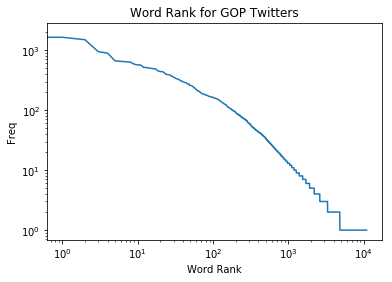

In [24]:
plt.loglog(sorted_word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('Word Rank for GOP Twitters')

(array([1.0439e+04, 2.0100e+02, 7.9000e+01, 4.6000e+01, 3.8000e+01,
        1.1000e+01, 1.1000e+01, 9.0000e+00, 7.0000e+00, 6.0000e+00,
        2.0000e+00, 4.0000e+00, 5.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 4.04800e+01, 7.99600e+01, 1.19440e+02, 1.58920e+02,
        1.98400e+02, 2.37880e+02, 2.77360e+02, 3.16840e+02, 3.56320e+02,
        3.95800e+02, 4.35280e+02, 4.74760e+02, 5.14240e+02, 5.53720e+02,
        5.93200e+02, 6.32680e+02, 6.72160e+02, 7.11640e+02, 7.51120e+02,
        7.90600e+02, 8.300

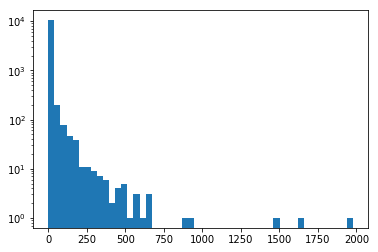

In [25]:
plt.hist(sorted_word_counts, bins=50, log=True)

### Visualise Positives vs. Negatives Ratio

In [26]:
label_count=pd.Series(labels).value_counts()
label_count

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

In [27]:
review_ratio = [opinion/sum(label_count)*100 for opinion in label_count]
print('Sentiment Ratio: ', review_ratio)
Pos_ratio = label_count['Positive']/sum(label_count)*100
print('Positive comments ratio: {0}%'.format(Pos_ratio))

Sentiment Ratio:  [61.22846225939009, 22.651575228894817, 16.119962511715087]
Positive comments ratio: 16.119962511715087%


Text(0.5, 1.0, 'Sentiment Ratio for GOP Twitters')

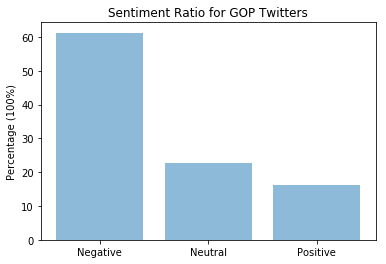

In [28]:
y_pos = range(len(label_count))
#plt.bar(y_pos,label_count,align='center', alpha=.5)
plt.bar(y_pos,review_ratio,align='center', alpha=.5)
plt.xticks(y_pos,label_count.index)
plt.ylabel('Percentage (100%)')
plt.title('Sentiment Ratio for GOP Twitters')

### Build WordCloud for GoP Twitter

In [29]:
text_label_pair_list = list(zip(tc_tweets,labels))
text_label_pair_list[0]

(['nancyleegrahn',
  'everyon',
  'feel',
  'climat',
  'chang',
  'question',
  'last',
  'night',
  'exact'],
 'Neutral')

In [30]:
#remove those neutral tweets as I am only interested in neg / pos ones
text_label_pair_list[:] = [tuple for tuple in text_label_pair_list if tuple[1]!='Neutral']

In [31]:
#split into train and test set, 90% for training set, 10% reserved for testing and evaluation
train, test = train_test_split(text_label_pair_list, test_size = .1, random_state=7)

In [32]:
train_pos = [tuple for tuple in text_label_pair_list if tuple[1]=='Positive']
train_neg = [tuple for tuple in text_label_pair_list if tuple[1]=='Negative']

In [33]:
#unzip texts
train_pos_texts, _ = list(zip(*train_pos))
train_neg_texts, _ = list(zip(*train_neg))

In [34]:
train_pos_texts_str = ' '.join([word for sublist in train_pos_texts
                                        for word in sublist])
train_neg_texts_str = ' '.join([word for sublist in train_neg_texts
                                        for word in sublist])

### Building bag of words model

In [36]:
def build_bow_features(words):
    return {word:True for word in words}

In [37]:
#build a list of tuples (BOW_dict, label) for all tweets
train_bow = [(build_bow_features(tuple[0]), tuple[1]) for tuple in train]
test_bow = [(build_bow_features(tuple[0]), tuple[1]) for tuple in test] 

In [38]:
print(len(train_bow),len(test_bow))

9656 1073


In [39]:
sentiment_classifier = NaiveBayesClassifier.train(train_bow)

In [40]:
nltk.classify.util.accuracy(sentiment_classifier, train_bow)*100

86.16404308202155

In [41]:
nltk.classify.util.accuracy(sentiment_classifier, test_bow)*100

81.17427772600186

In [44]:
test_comment_dicts, test_labels = list(zip(*test_bow))
preds = [sentiment_classifier.classify(comment_dict) for comment_dict in test_comment_dicts]
pred_vs_observ = pd.DataFrame(np.array([test_labels,preds]).T,columns=['observation','prediction'])
pred_vs_observ.transpose()

,0,1,2,3,4,5,6,7,8,9,...,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072
observation,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Positive,Positive,...,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative
prediction,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Positive,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative
